<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRA1: Deep Reinforcement Learning

#### AUTOR: Mario Ubierna San Mamés
 

En esta práctica se hará un estudio sobre el entorno **highway-env**, donde inicialmente se realizará una exploración sobre el entorno, posteriormente implementaremos un agente DQN y finalmente mejoraremos el primer agente implementado

## 0. Contexto

**Highway-env** es un problema de conducción autónoma, donde tenemos múltiples carriles y varios coches transitando. Nuestro objetivo es que el agente sea capaz de controlar el vehículo con el fin de:

- Evitar colisiones con otros vehículos.
- Tener la máxima velocidad posible.
- Mantenerse en el carril derecho lo más posible.

El entorno se considera superado cuando en el tiempo de observación máximo establecido, se han verificado las tres condiciones anteriores.

![Alt Text](https://raw.githubusercontent.com/eleurent/highway-env/gh-media/docs/media/highway-env.gif?raw=true)

## 1. Entorno

Lo primero de todo es cargar las librerías necesarias:

In [1]:
import gym
import highway_env
from collections import namedtuple, deque
from copy import deepcopy, copy
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import time

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.1 (0.5 ptos) - </strong> Exploración del entorno y representación de una ejecución aleatoria:
</div>

#### Exploración del entorno

Carga del entorno:

In [2]:
# Definimos el entorno
env = gym.make("highway-v0")

Información básica del entorno:

In [3]:
print("El espacio de acciones es {} ".format(env.action_space))
print("La dimensión del espacio de acciones es: {}".format(env.action_space.n))
# print("Las acciones por defecto son {}".format(str(env.action_type.actions_indexes)))
print("El espacio de observaciones es {} ".format(env.observation_space))
print("La dimensión del espacio de estados: {}".format(env.observation_space.shape[0]))
print("El rango de recompensas es {} ".format(env.reward_range))

El espacio de acciones es Discrete(5) 
La dimensión del espacio de acciones es: 5
El espacio de observaciones es Box([[-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]], [[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]], (5, 5), float32) 
La dimensión del espacio de estados: 5
El rango de recompensas es (-inf, inf) 


De la anterior ejecución podemos observar que, por defecto tanto la dimensión del espacio de acciones como de estados es 5. Estos valores vienen predefinidos a la hora de cargar el entorno **highway-v0**.  
  
Para saber más sobre la configuración por defecto del entorno ejecutamos la siguiente instrucción:

In [4]:
env.env.default_config()

{'observation': {'type': 'Kinematics'},
 'action': {'type': 'DiscreteMetaAction'},
 'simulation_frequency': 15,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 150,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 4,
 'vehicles_count': 50,
 'controlled_vehicles': 1,
 'initial_lane_id': None,
 'duration': 40,
 'ego_spacing': 2,
 'vehicles_density': 1,
 'collision_reward': -1,
 'right_lane_reward': 0.1,
 'high_speed_reward': 0.4,
 'lane_change_reward': 0,
 'reward_speed_range': [20, 30],
 'offroad_terminal': False}

Como podemos ver obtenemos la siguiente información:  
- El tipo de observación es Kinematics, esto lo que significa es que el espacio de estados va a ser una matriz del tipo VxF, donde V es el número de vehículos cercanos a nuestro coche y F el número de características (['presence', 'x', 'y', 'vx', 'vy']).

- El tipo de acciones es DiscreteMetaAction, en este caso hay 5 acciones. La primera es movernos al carril de la izquierda "0", la segunda es un movimiento ilegal o mantenernos en el carril actual a la velocidad actual "1" (cuando se produce un cambio de carril en el límite de la carretera, o cuando la acelaración o desaceleración es mayor o menor que la velocidad máxima/mínima) "1", la tercera es movernos al carril de la derecha "2", la cuarta es aumentar la velocidad "3" y la quinta reducir la velocidad "4".

- El número de carriles es 4, se puede modificar para añadir más o menos.

- El número de vehículos es 50 y al igual que antes se puede modificar.

- La recompensa por colisión es -1.

- La recompensa por estar en el carril de la derecha es 0.1.

- La recompensa por alcanzar una alta velocidad es 0.4.

- La recompensa por cambiar de carril es 0.

- Y la recompensa por aumentar o disminuir la velocidad varía entre 20 y 30 dependiendo de forma lineal a su velocidad.

A continuación podemos ver un ejemplo de una acción tomada aleatoriamente y todas las posibles acciones que podemos tomar:

In [5]:
print("Acción aleatoria tomada {}".format(env.action_space.sample()))
print("Las posibles acciones son {}".format(env.action_type.actions_indexes))

Acción aleatoria tomada 1
Las posibles acciones son {'LANE_LEFT': 0, 'IDLE': 1, 'LANE_RIGHT': 2, 'FASTER': 3, 'SLOWER': 4}


Para concluir con la exploración del entorno, vamos a mostrar un ejemplo de un estado según el espacio de observaciones por defecto junto el nombre de cada columna:

In [6]:
print("Un estado aleatorio sería \n{}".format(env.observation_space.sample()))
print("El nombre de cada columna (característica \"F\") es {}".format(env.env.observation_type.features))

Un estado aleatorio sería 
[[ 0.8265906   0.50306684  0.5009782   1.6739941  -0.3443133 ]
 [-1.712709   -1.0283263  -1.71719     1.5008764  -0.23842251]
 [ 0.5687505  -0.7425254   0.24336001 -0.15182547  0.6448985 ]
 [-0.4683048  -0.40205896  0.12377669  0.16236722  0.79914373]
 [ 0.34687257  0.5101396  -0.66911715  0.48765206  1.0748152 ]]
El nombre de cada columna (característica "F") es ['presence', 'x', 'y', 'vx', 'vy']


#### Representación de una ejecución aleatoria

Obs inicial:


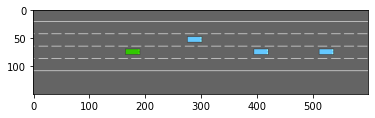

[[ 1.          0.9121329   0.5         0.3125      0.        ]
 [ 1.          0.10041855 -0.25       -0.02218991  0.        ]
 [ 1.          0.20834038  0.         -0.0274212   0.        ]
 [ 1.          0.31483275  0.         -0.02033501  0.        ]
 [ 1.          0.4255051  -0.5        -0.01338776  0.        ]]

Acción: LANE_LEFT -> recommpensa: 0.8222222222222223
Nuevo estado:


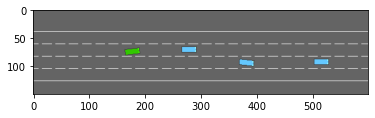

[[ 1.          1.          0.2917827   0.31063917 -0.03405233]
 [ 1.          0.09108479 -0.0417827  -0.02901597  0.03405233]
 [ 1.          0.18575749  0.23050907 -0.08366203  0.05962055]
 [ 1.          0.30694053  0.20821731 -0.02529695  0.03405233]
 [ 1.          0.41877183 -0.2917827  -0.02396802  0.03405233]]

Acción: LANE_LEFT -> recommpensa: 0.7999999999999999
Nuevo estado:


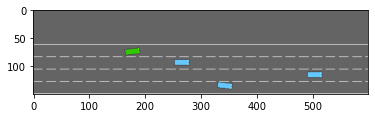

[[ 1.          1.          0.02809043  0.31064758 -0.0339754 ]
 [ 1.          0.07918406  0.22190957 -0.03582969  0.0339754 ]
 [ 1.          0.15064542  0.69668037 -0.08328228  0.06127327]
 [ 1.          0.29625008  0.47190955 -0.03323152  0.0339754 ]
 [ 1.          0.40866515 -0.02809043 -0.032185    0.0339754 ]]

Acción: FASTER -> recommpensa: 0.9105482353831814
Nuevo estado:


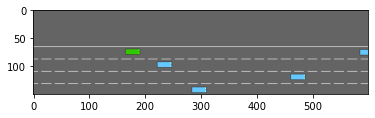

[[ 1.          1.         -0.01898986  0.36431098  0.00248997]
 [ 1.          0.05096482  0.26898986 -0.09278745 -0.00248997]
 [ 1.          0.10745657  0.7796277  -0.12147895 -0.00296829]
 [ 1.          0.26887357  0.51898986 -0.09132659 -0.00248997]
 [ 1.          0.38148785  0.01898986 -0.09142865 -0.00248997]]

Acción: FASTER -> recommpensa: 0.9294396281688483
Nuevo estado:


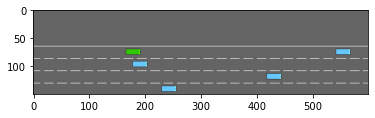

[[ 1.          1.         -0.00151278  0.3731685   0.0021715 ]
 [ 1.          0.01137714  0.2515128  -0.10320764 -0.0021715 ]
 [ 1.          0.05859883  0.75299656 -0.1209567  -0.00352853]
 [ 1.          0.22962297  0.50151277 -0.10306487 -0.0021715 ]
 [ 1.          0.34201092  0.00151278 -0.10411952 -0.0021715 ]]

Acción: LANE_RIGHT -> recommpensa: 0.022222222222222216
Nuevo estado:


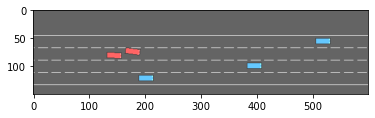

[[ 1.          1.          0.20532805  0.24519372  0.03347299]
 [ 1.          0.0212572   0.54415876  0.01314372 -0.03346798]
 [ 1.         -0.02938641  0.08360266 -0.07716142 -0.02417532]
 [ 1.          0.19781405  0.29467195  0.02293511 -0.03347299]
 [ 1.          0.30963904 -0.20532805  0.02116675 -0.03347299]]
Episodio terminado después de 5 pasos y la recompensa fue 3.484432307996474


In [7]:
obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = env.action_space.sample()
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
    print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.2 (0.5 ptos) - </strong> Explicar los diferentes espacios de observaciones y de acciones:
</div>

Resuelto en el informe

## 2. Agente de mejorado

In [8]:
class experienceReplayBuffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer', 
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size, 
                                   replace=False)
        # Use asterisk operator to unpack deque 
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

In [9]:
class NeuralNet(torch.nn.Module):  

    def __init__(self, env, learning_rate=1e-3):
        
        """
        Params
        ======
        n_inputs: tamaño del espacio de estadps
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        """
        ######################################
        ##TODO: Inicializar parámetros
        super(NeuralNet, self).__init__()
        self.n_inputs = env.observation_space.shape[0] * env.observation_space.shape[1]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        
        #######################################
        ##TODO: Neural network
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.n_outputs, bias=True),
        )
        
        #######################################
        ##TODO: Initialize optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)


    ### e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acción random
        else:
            qvals = self.get_qvals(np.reshape(state, (25,)))  # acción del cálculo de Q para esta acción
#             print(state)
#             print(qvals)
            action= torch.max(qvals, dim=-1)[1].item()
        return action
    
    
    def get_qvals(self, state):
        if type(state) is tuple:
#             print("*******************")
#             print("ACTUALIZCION")
#             print(state)
            state = np.array([np.ravel(s) for s in state])
#             print(state)
#             print("*******************")
        state_t = torch.FloatTensor(state)
        return self.model(state_t)

In [10]:
class DQNAgent:
    
    ######################################
    ##TODO 1: Declarar variables
    def __init__(self, env, main_network, buffer, epsilon=0.1, eps_decay=0.99, batch_size=32):
        
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) 
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = 100 # bloque de los X últimos episodios de los que se calculará la media de recompensas
        self.initialize()
        
    ######################################
    ##TODO 2: Inicializar otras variables necesarias
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.update_position = []
        self.history_loss = []
        self.update_epsilon = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()
    
    ######################################
    ##TODO 3: Tomar paso siguiente
    def take_step(self, eps, mode='train'):
        if mode == 'explore': 
            action = self.env.action_space.sample()  # acción aleatoria en el burn-in
        else:
            action = self.main_network.get_action(self.state0, eps) # acción a partir del valor de Q (elección de la acción con mejor Q)
            self.step_count += 1
            
        #TODO: tomar 'step' i obtener nuevo estado y recompensa. Guardar la experiencia en el buffer
        new_state, reward, done, _ = self.env.step(action)
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state)
        self.state0 = new_state.copy()
        
        #TODO: resetear entorno 'if done'
        if done:
            self.update_position.append(self.state0[0]) # Guardamos la posición final de cada episodio
            self.state0 = self.env.reset()
        return done

    ## TRAINING
    def train(self, gamma=0.99, max_episodes=50000, 
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000):
        
        self.gamma = gamma

        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

            
        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')
                
                #################################################################################
                #####TODO 4:  Actualizar la red principal según la frecuencia establecida #######
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                    
                ########################################################################################
                ###TODO 6: Sincronizar red principal y red objetivo según la frecuencia establecida#####
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict()
                    )
                    self.sync_eps.append(episode)
                
                if gamedone:                   
                    episode += 1
                    
                    # Guardamos la evolución de la pérdida
                    self.history_loss.append(np.mean(self.update_loss))
                        
                    self.update_loss = []
                                    
                    #######################################################################################
                    ###TODO 7: calcular la media de recompensa de los últimos X episodios, y almacenar
                    self.training_rewards.append(self.total_reward)
                    mean_rewards = np.mean(
                        self.training_rewards[-self.nblock:]
                    )
                    self.mean_training_rewards.append(mean_rewards)

                    self.update_epsilon.append(self.epsilon) # Guardamos la evolución de epsilon
                    
                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(
                        episode, mean_rewards, self.epsilon), end="")
                    
                    #######################################################################################
                    ### TODO 8: Comprobar que todavía quedan episodios. Parar el aprendizaje si se llega al límite
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached')
                        break
                    
                    #################################################################################
                    ######TODO 9: Actualizar epsilon según la velocidad de decaimiento fijada########
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)

                    
    #####################################         
    #####TODO 5: cálculo de la pérdida###
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores 
        states, actions, rewards, dones, next_states = [i for i in batch] 
        rewards_vals = torch.FloatTensor(rewards)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1)
        dones_t = torch.ByteTensor(dones)
        
#         print(states)
#         print("*******************")
#         print(actions)
#         print("*******************")
#         print(actions_vals)
#         print("*******************")
#         print(self.main_network.get_qvals(states))
        
        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
        # Obtenemos los valores de Q objetivo. El parámetro detach() evita que estos valores actualicen la red objetivo
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estados terminales
        
        #################################################################################
        ### TODO: Calcular ecuación de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        #################################################################################
        ### TODO: Calcular la pérdida (MSE)
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        
        return loss

    
    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        self.update_loss.append(loss.detach().numpy())
        
    def plot_rewards(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.title("Evolución de las recompensas")
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc="upper left")
        plt.show()
        
    def plot_loss(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.history_loss)
        plt.title("Evolución de la pérdida")
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.show()
        
    def plot_epsilon(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.update_epsilon)
        plt.title("Evolución de epsilon")
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.show()

In [21]:
# lr = 0.001            # Velocidad de aprendizaje
# BATCH_SIZE = 32       # Tamaño del batch
# MAX_EPISODES = 5000   # Número de episodios
# BURN_IN = 1        # Número de episodios para rellenar el buffer
# DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
# DNN_SYNC = 1000       # Frecuencia de sincronización con la red objetivo
# MEMORY_SIZE = 10   # Capacidad máxima del buffer
# GAMMA = 0.99          # Factor de descuento
# EPSILON = 0.01           # Epsilon
# EPSILON_DECAY = 0.99   # Decaimiento de epsilon

lr = 0.001            # Velocidad de aprendizaje
BATCH_SIZE = 64      # Tamaño del batch
MAX_EPISODES = 1500   # Número de episodios
BURN_IN = 1000        # Número de episodios para rellenar el buffer
DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
DNN_SYNC = 100       # Frecuencia de sincronización con la red objetivo
MEMORY_SIZE = 10000   # Capacidad máxima del buffer
GAMMA = 0.8          # Factor de descuento
EPSILON = 1           # Epsilon
EPSILON_DECAY = 0.99   # Decaimiento de epsilon

In [22]:
# Carga de la red neuronal
dqn = NeuralNet(env, learning_rate=lr)

# Creación del buffer
buffer = experienceReplayBuffer(
    memory_size=MEMORY_SIZE, 
    burn_in=BURN_IN
)

# Creación del agente
agent_dqn = DQNAgent(
    env=env,
    main_network=dqn,
    buffer=buffer,
    epsilon=EPSILON,
    eps_decay=EPSILON_DECAY,
    batch_size=BATCH_SIZE
)

# Entrenamos el agente
agent_dqn.train(
    gamma=GAMMA, 
    max_episodes=MAX_EPISODES, 
    batch_size=BATCH_SIZE,  
    dnn_update_frequency=DNN_UPD, 
    dnn_sync_frequency=DNN_SYNC
)

Filling replay buffer...
Training...


<ipython-input-10-abf80ff9db09>:145: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1273.)
  qvals_next[dones_t] = 0 # 0 en estados terminales


Episode 1500 Mean Rewards 22.87 Epsilon 0.01		118606165716			
Episode limit reached


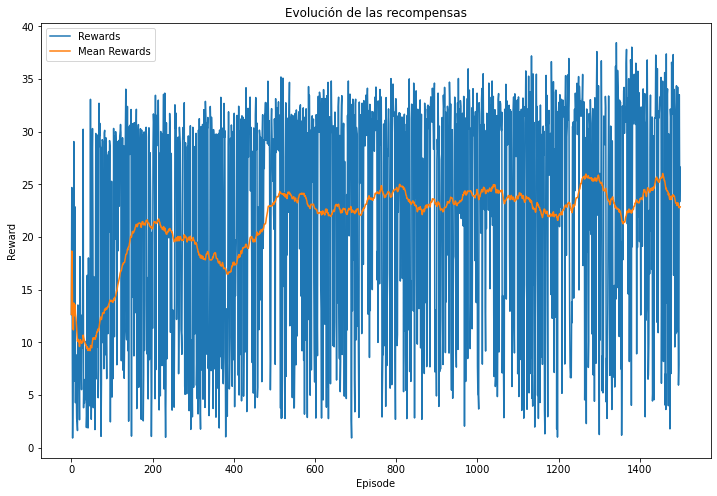

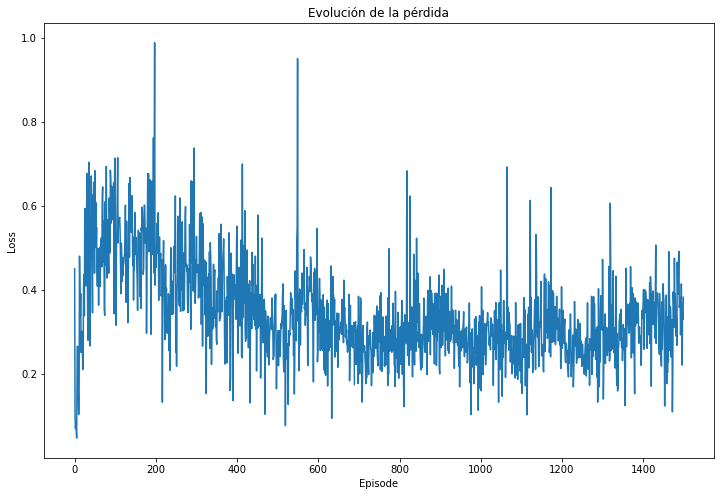

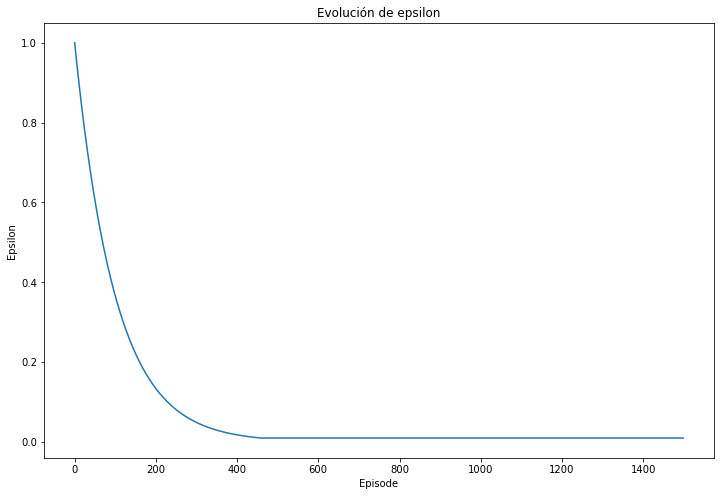

In [23]:
agent_dqn.plot_rewards()
agent_dqn.plot_loss()
agent_dqn.plot_epsilon()

In [24]:
# Guardamos el modelo entrenado
trained_model = {
    "state_dic" : agent_dqn.main_network.state_dict()
}
torch.save(trained_model, "DQN.pth")

Obs inicial:


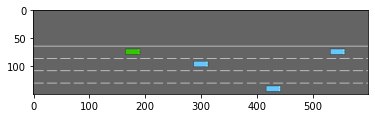

[[ 1.          0.8978058   0.          0.3125      0.        ]
 [ 1.          0.11085349  0.25       -0.03663334  0.        ]
 [ 1.          0.2283251   0.75       -0.01782046  0.        ]
 [ 1.          0.33355933  0.         -0.03790278  0.        ]
 [ 1.          0.4278442   0.5        -0.04465329  0.        ]]

Acción: FASTER -> recommpensa: 0.9105482353831814
Nuevo estado:


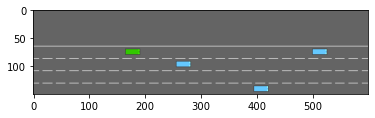

[[ 1.          1.          0.          0.36431947  0.        ]
 [ 1.          0.08207297  0.25       -0.09712965  0.        ]
 [ 1.          0.20822376  0.75       -0.0717173   0.        ]
 [ 1.          0.304106    0.         -0.0991511   0.        ]
 [ 1.          0.3968118   0.5        -0.09940007  0.        ]]

Acción: LANE_LEFT -> recommpensa: 0.9294396281688483
Nuevo estado:


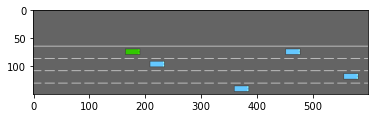

[[ 1.          1.          0.          0.37317482  0.        ]
 [ 1.          0.03944955  0.25       -0.11429483  0.        ]
 [ 1.          0.17708299  0.75       -0.08211113  0.        ]
 [ 1.          0.26068947  0.         -0.11612748  0.        ]
 [ 1.          0.35455555  0.5        -0.10998958  0.        ]]

Acción: FASTER -> recommpensa: 0.9326679449316199
Nuevo estado:


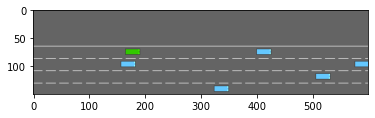

[[ 1.          1.          0.          0.3746881   0.        ]
 [ 1.         -0.00782134  0.25       -0.12176014  0.        ]
 [ 1.          0.14367406  0.75       -0.08460569  0.        ]
 [ 1.          0.2127791   0.         -0.12306095  0.        ]
 [ 1.          0.30997178  0.5        -0.11259535  0.        ]]

Acción: FASTER -> recommpensa: 0.9332196262840239
Nuevo estado:


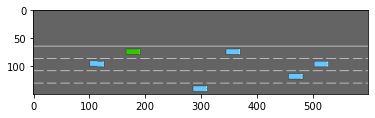

[[ 1.          1.          0.          0.3749467   0.        ]
 [ 1.          0.10963931  0.75       -0.08551692  0.        ]
 [ 1.          0.16280746  0.         -0.12668659  0.        ]
 [ 1.          0.2647337   0.5        -0.1135316   0.        ]
 [ 1.          0.30669385  0.25       -0.16484965  0.        ]]

Acción: LANE_RIGHT -> recommpensa: 0.9555361243586344
Nuevo estado:


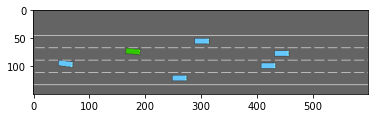

[[ 1.          1.          0.2079074   0.37338257  0.03469348]
 [ 1.          0.07630108  0.5420926  -0.08442164 -0.03469348]
 [ 1.          0.11268755 -0.2079074  -0.12709731 -0.03469348]
 [ 1.          0.22019644  0.29209262 -0.11238916 -0.03469348]
 [ 1.          0.24262407  0.04209261 -0.15831506 -0.03469348]]

Acción: LANE_RIGHT -> recommpensa: 0.9777744572148391
Nuevo estado:


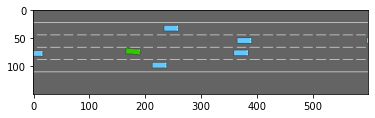

[[ 1.          1.          0.4735581   0.373451    0.03403204]
 [ 1.          0.04338258  0.2764419  -0.08485364 -0.03403204]
 [ 1.          0.06254737 -0.4735581  -0.12822454 -0.03403204]
 [ 1.          0.17610747  0.0264419  -0.11272603 -0.03403204]
 [ 1.          0.18117222 -0.2235581  -0.15332429 -0.03403204]]

Acción: FASTER -> recommpensa: 0.9777772103326393
Nuevo estado:


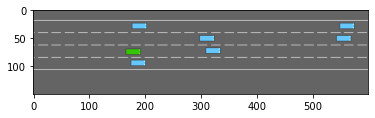

[[ 1.          1.          0.51800424  0.37498954 -0.00276679]
 [ 1.          0.00885928  0.23199578 -0.08669456  0.00276679]
 [ 1.          0.01063097 -0.51800424 -0.1302304   0.00276679]
 [ 1.          0.12019796 -0.26800424 -0.1502558   0.00276679]
 [ 1.          0.13045748 -0.01800422 -0.1144442   0.00276679]]

Acción: SLOWER -> recommpensa: 0.8672294454248987
Nuevo estado:


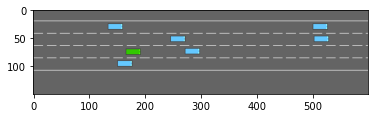

[[ 1.          1.          0.50173676  0.32317448 -0.00196777]
 [ 1.         -0.01330371  0.24826322 -0.03514659  0.00196777]
 [ 1.         -0.02892269 -0.50173676 -0.0785084   0.00196777]
 [ 1.          0.07342561 -0.25173676 -0.09446142  0.00196777]
 [ 1.          0.09721982 -0.00173677 -0.06275979  0.00196777]]

Acción: SLOWER -> recommpensa: 0.7377898976547678
Nuevo estado:


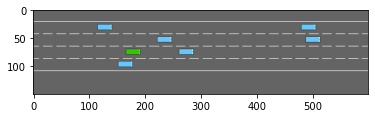

[[ 1.0000000e+00  1.0000000e+00  4.9925703e-01  2.6250568e-01
   7.6818753e-05]
 [ 1.0000000e+00 -1.2700801e-02  2.5074297e-01  2.5274834e-02
  -7.6818753e-05]
 [ 1.0000000e+00 -4.5597851e-02 -4.9925703e-01 -1.7700542e-02
  -7.6818753e-05]
 [ 1.0000000e+00  5.0993726e-02 -2.4925704e-01 -3.0448524e-02
  -7.6818753e-05]
 [ 1.0000000e+00  8.6803801e-02  7.4296439e-04 -2.1967269e-03
  -7.6818753e-05]]

Acción: LANE_LEFT -> recommpensa: 0.693447979623302
Nuevo estado:


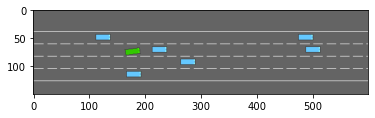

[[ 1.          1.          0.29255903  0.24996431 -0.03302945]
 [ 1.          0.00126653  0.45744097  0.0375788   0.03302945]
 [ 1.          0.04325136 -0.04255904 -0.01513456  0.03302945]
 [ 1.         -0.04872741 -0.29255903 -0.00487888  0.03302945]
 [ 1.          0.08980908  0.20744096  0.01024946  0.03302945]]

Acción: SLOWER -> recommpensa: 0.6896679838559931
Nuevo estado:


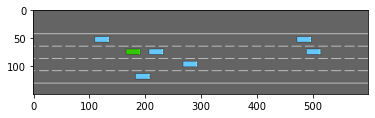

[[ 1.00000000e+00  1.00000000e+00  2.39056110e-01  2.50363976e-01
  -7.86038581e-04]
 [ 1.00000000e+00  1.59641281e-02  5.10943890e-01  3.69455777e-02
   7.86038581e-04]
 [ 1.00000000e+00  3.73489484e-02  1.09438868e-02 -1.32463155e-02
   7.86038581e-04]
 [ 1.00000000e+00  9.36012790e-02  2.60943890e-01  9.75691341e-03
   7.86038581e-04]
 [ 1.00000000e+00  2.78805226e-01 -2.39056110e-01 -5.09383529e-03
   7.86038581e-04]]

Acción: LANE_LEFT -> recommpensa: 0.6667998048302013
Nuevo estado:


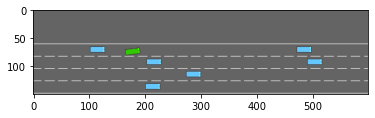

[[ 1.0000000e+00  1.0000000e+00  3.9169706e-02  2.4806264e-01
  -3.1561613e-02]
 [ 1.0000000e+00  3.2097768e-02  7.1083027e-01  3.9013181e-02
   3.1561613e-02]
 [ 1.0000000e+00  3.3814039e-02  2.1083029e-01 -9.0550883e-03
   3.1561613e-02]
 [ 1.0000000e+00  9.8885372e-02  4.6083030e-01  1.1963014e-02
   3.1561613e-02]
 [ 1.0000000e+00  2.7854791e-01 -3.9169706e-02 -8.1049092e-04
   3.1561613e-02]]

Acción: LANE_LEFT -> recommpensa: 0.6666894184123944
Nuevo estado:


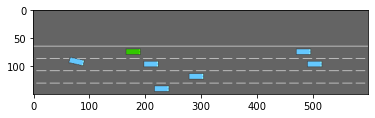

[[ 1.0000000e+00  1.0000000e+00 -1.0747719e-02  2.5001004e-01
  -5.6263543e-04]
 [ 1.0000000e+00  2.9840142e-02  2.6074773e-01 -9.4336346e-03
   5.6263543e-04]
 [ 1.0000000e+00  4.7004797e-02  7.6074773e-01  3.6829311e-02
   5.6263543e-04]
 [ 1.0000000e+00  1.0299788e-01  5.1074773e-01  9.9156741e-03
   5.6263543e-04]
 [ 1.0000000e+00  2.7789193e-01  1.0747719e-02 -1.0781417e-03
   5.6263543e-04]]

Acción: FASTER -> recommpensa: 0.77721879005551
Nuevo estado:


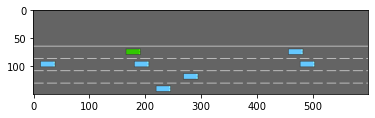

[[ 1.          1.         -0.00190567  0.30181724  0.00156447]
 [ 1.          0.01376009  0.25190568 -0.05992874 -0.00156447]
 [ 1.          0.0491326   0.7519057  -0.01521885 -0.00156447]
 [ 1.          0.0943855   0.5019057  -0.04199725 -0.00156447]
 [ 1.          0.2651775   0.00190567 -0.05144506 -0.00156447]]

Acción: FASTER -> recommpensa: 0.9066551946331199
Nuevo estado:


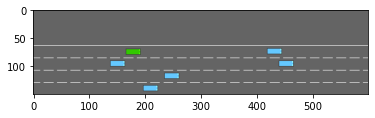

[[ 1.0000000e+00  1.0000000e+00  7.9800718e-04  3.6249462e-01
  -2.8661363e-05]
 [ 1.0000000e+00 -2.4709843e-02  2.4920200e-01 -1.1949869e-01
   2.8661363e-05]
 [ 1.0000000e+00  2.8288040e-02  7.4920201e-01 -7.6142758e-02
   2.8661363e-05]
 [ 1.0000000e+00  6.2854744e-02  4.9920198e-01 -1.0278634e-01
   2.8661363e-05]
 [ 1.0000000e+00  2.3012710e-01 -7.9800718e-04 -1.1087337e-01
   2.8661363e-05]]

Acción: FASTER -> recommpensa: 0.9287743533077427
Nuevo estado:


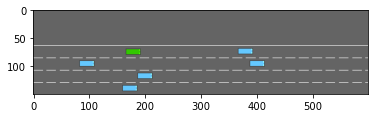

[[ 1.00000000e+00  1.00000000e+00  1.13483104e-04  3.72862965e-01
  -1.05632455e-04]
 [ 1.00000000e+00 -4.72979061e-03  7.49886513e-01 -8.67640227e-02
   1.05632455e-04]
 [ 1.00000000e+00  1.92047246e-02  4.99886513e-01 -1.13272190e-01
   1.05632455e-04]
 [ 1.00000000e+00  1.83472961e-01 -1.13483104e-04 -1.20147079e-01
   1.05632455e-04]
 [ 1.00000000e+00  2.02466369e-01  2.49886513e-01 -1.21508099e-01
   1.05632455e-04]]

Acción: IDLE -> recommpensa: 0.9325542572850644
Nuevo estado:


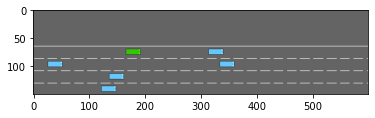

[[ 1.00000000e+00  1.00000000e+00 -5.06179240e-05  3.74634802e-01
   4.20289507e-06]
 [ 1.00000000e+00 -2.65564863e-02  5.00050604e-01 -1.15166865e-01
  -4.20289507e-06]
 [ 1.00000000e+00 -3.99132408e-02  7.50050604e-01 -8.87957066e-02
  -4.20289507e-06]
 [ 1.00000000e+00  1.35169119e-01  5.06179240e-05 -1.20950483e-01
  -4.20289507e-06]
 [ 1.00000000e+00  1.53434426e-01  2.50050604e-01 -1.23271674e-01
  -4.20289507e-06]]

Acción: SLOWER -> recommpensa: 0.8226519630196237
Nuevo estado:


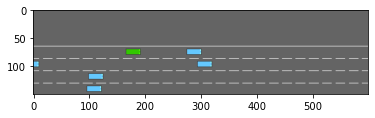

[[ 1.0000000e+00  1.0000000e+00 -7.0480824e-06  3.2311812e-01
   6.1580049e-06]
 [ 1.0000000e+00  9.9443287e-02  7.0480824e-06 -6.8569727e-02
  -6.1580049e-06]
 [ 1.0000000e+00  1.1662020e-01  2.5000703e-01 -7.1727544e-02
  -6.1580049e-06]
 [ 1.0000000e+00  4.3242079e-01  7.0480824e-06 -5.4644819e-02
  -6.1580049e-06]
 [ 1.0000000e+00  4.6780422e-01  2.5000703e-01 -7.2725527e-02
  -6.1580049e-06]]

Acción: LANE_RIGHT -> recommpensa: 0.8260931761934623
Nuevo estado:


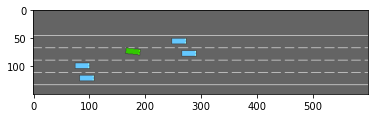

[[ 1.          1.          0.2072425   0.3124653   0.03404482]
 [ 1.          0.07542994 -0.2072425  -0.05714028 -0.03404482]
 [ 1.          0.09120385  0.0427575  -0.06103034 -0.03404482]
 [ 1.          0.413838   -0.2072425  -0.04394928 -0.03404482]
 [ 1.          0.44207755  0.0427575  -0.06156267 -0.03404482]]

Acción: LANE_RIGHT -> recommpensa: 0.8451059449349088
Nuevo estado:


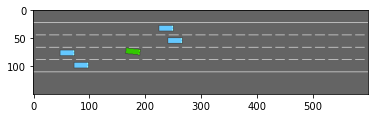

[[ 1.          1.          0.4715383   0.31094557  0.03410286]
 [ 1.          0.054196   -0.4715383  -0.05491794 -0.03410286]
 [ 1.          0.06829108 -0.2215383  -0.05945124 -0.03410286]
 [ 1.          0.3977539  -0.4715383  -0.04239396 -0.03410286]
 [ 1.          0.41903025 -0.2215383  -0.0595727  -0.03410286]]

Acción: LANE_RIGHT -> recommpensa: 0.8667797093176864
Nuevo estado:


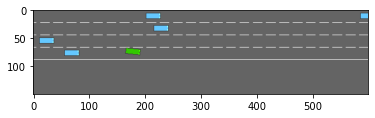

[[ 1.          1.          0.72409034  0.31089443  0.03215634]
 [ 1.          0.03337473 -0.72409034 -0.0542276  -0.03215634]
 [ 1.          0.04554835 -0.47409034 -0.05932759 -0.03215634]
 [ 1.          0.38182658 -0.72409034 -0.04231375 -0.03215634]
 [ 1.          0.39630812 -0.47409034 -0.05908654 -0.03215634]]

Acción: FASTER -> recommpensa: 0.9772342197089182
Nuevo estado:


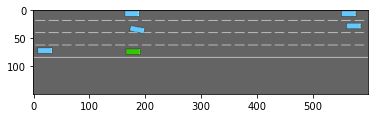

[[ 1.          1.          0.7680696   0.3643203  -0.00245048]
 [ 1.         -0.00132118 -0.7680696  -0.10706908  0.00245048]
 [ 1.          0.00814026 -0.4350393  -0.11733246  0.05020769]
 [ 1.          0.35178995 -0.7680696  -0.09571651  0.00245048]
 [ 1.          0.3596342  -0.5180696  -0.11210869  0.00245048]]

Acción: FASTER -> recommpensa: 0.9961095959961704
Nuevo estado:


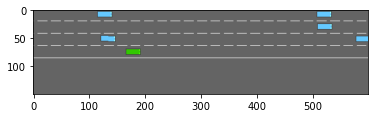

[[ 1.          1.          0.7513857   0.37317073 -0.00205092]
 [ 1.         -0.03980207 -0.25294396 -0.12002723  0.01730601]
 [ 1.         -0.0461893  -0.7513857  -0.11538295  0.00205092]
 [ 1.          0.31136465 -0.7513857  -0.10454939  0.00205092]
 [ 1.          0.3127196  -0.5013857  -0.12058336  0.00205092]]

Acción: IDLE -> recommpensa: 0.999335175727803
Nuevo estado:


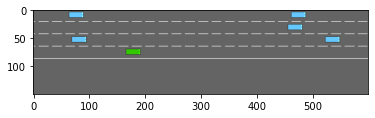

[[ 1.00000000e+00  1.00000000e+00  7.48879015e-01  3.74688327e-01
   1.95341243e-04]
 [ 1.00000000e+00  2.64184028e-01 -4.98879015e-01 -1.21750206e-01
  -1.95341243e-04]
 [ 1.00000000e+00  2.69178867e-01 -7.48879015e-01 -1.06054604e-01
  -1.95341243e-04]
 [ 1.00000000e+00  3.24931651e-01 -2.48879015e-01 -1.25267833e-01
  -1.95341243e-04]
 [ 1.00000000e+00  4.68033880e-01  1.12098060e-03 -1.18742868e-01
  -1.95341243e-04]]

Acción: FASTER -> recommpensa: 0.9998863893537878
Nuevo estado:


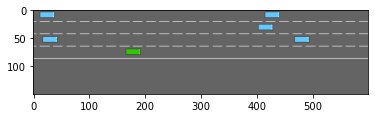

[[ 1.0000000e+00  1.0000000e+00  7.4993855e-01  3.7494671e-01
   1.1894532e-04]
 [ 1.0000000e+00  2.1548328e-01 -4.9993855e-01 -1.2168046e-01
  -1.1894532e-04]
 [ 1.0000000e+00  2.2669595e-01 -7.4993855e-01 -1.0630554e-01
  -1.1894532e-04]
 [ 1.0000000e+00  2.7469379e-01 -2.4993855e-01 -1.2588018e-01
  -1.1894532e-04]
 [ 1.0000000e+00  4.2050388e-01  6.1456165e-05 -1.1884209e-01
  -1.1894532e-04]]

Acción: LANE_RIGHT -> recommpensa: 0.9999805852772341
Nuevo estado:


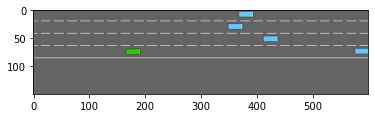

[[ 1.0000000e+00  1.0000000e+00  7.5006813e-01  3.7499091e-01
  -1.3961503e-05]
 [ 1.0000000e+00  1.6685846e-01 -5.0006813e-01 -1.2141688e-01
   1.3961503e-05]
 [ 1.0000000e+00  1.8416370e-01 -7.5006813e-01 -1.0634686e-01
   1.3961503e-05]
 [ 1.0000000e+00  2.2427396e-01 -2.5006813e-01 -1.2622005e-01
   1.3961503e-05]
 [ 1.0000000e+00  3.7298566e-01 -6.8131631e-05 -1.1872966e-01
   1.3961503e-05]]

Acción: LANE_RIGHT -> recommpensa: 0.9999966822523009
Nuevo estado:


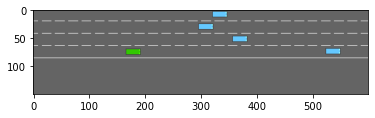

[[ 1.00000000e+00  1.00000000e+00  7.50002384e-01  3.74998450e-01
  -6.83385497e-06]
 [ 1.00000000e+00  1.18344463e-01 -5.00002384e-01 -1.21135198e-01
   6.83385497e-06]
 [ 1.00000000e+00  1.41622990e-01 -7.50002384e-01 -1.06355913e-01
   6.83385497e-06]
 [ 1.00000000e+00  1.73737139e-01 -2.50002354e-01 -1.26470298e-01
   6.83385497e-06]
 [ 1.00000000e+00  3.25520724e-01 -2.36252413e-06 -1.18583865e-01
   6.83385497e-06]]

Acción: LANE_RIGHT -> recommpensa: 0.9999994330359527
Nuevo estado:


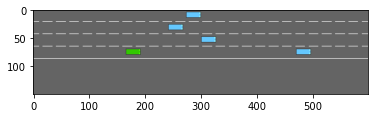

[[ 1.00000000e+00  1.00000000e+00  7.49995887e-01  3.74999732e-01
   9.64643050e-07]
 [ 1.00000000e+00  6.99414462e-02 -4.99995887e-01 -1.20864138e-01
  -9.64643050e-07]
 [ 1.00000000e+00  9.90794003e-02 -7.49995887e-01 -1.06362835e-01
  -9.64643050e-07]
 [ 1.00000000e+00  1.23110823e-01 -2.49995887e-01 -1.26666471e-01
  -9.64643050e-07]
 [ 1.00000000e+00  2.78114885e-01  4.11296287e-06 -1.18435659e-01
  -9.64643050e-07]]

Acción: LANE_RIGHT -> recommpensa: 0.999999903112515
Nuevo estado:


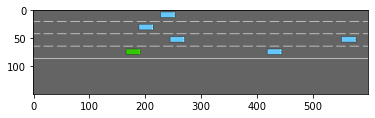

[[ 1.0000000e+00  1.0000000e+00  7.4999994e-01  3.7499994e-01
   3.8949275e-07]
 [ 1.0000000e+00  2.1644181e-02 -4.9999994e-01 -1.2060744e-01
  -3.8949275e-07]
 [ 1.0000000e+00  5.6532562e-02 -7.4999994e-01 -1.0637256e-01
  -3.8949275e-07]
 [ 1.0000000e+00  7.2414458e-02 -2.4999994e-01 -1.2681875e-01
  -3.8949275e-07]
 [ 1.0000000e+00  2.3076783e-01  6.2156808e-08 -1.1829070e-01
  -3.8949275e-07]]

Acción: IDLE -> recommpensa: 0.9999999834430687
Nuevo estado:


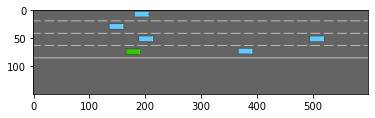

[[ 1.0000000e+00  1.0000000e+00  7.5000024e-01  3.7500000e-01
  -6.5062117e-08]
 [ 1.0000000e+00  1.3981194e-02 -7.5000024e-01 -1.0638574e-01
   6.5062117e-08]
 [ 1.0000000e+00  2.1664483e-02 -2.5000024e-01 -1.2693277e-01
   6.5062117e-08]
 [ 1.0000000e+00 -2.6553037e-02 -5.0000024e-01 -1.2036471e-01
   6.5062117e-08]
 [ 1.0000000e+00  1.8347792e-01 -2.4674463e-07 -1.1815025e-01
   6.5062117e-08]]

Acción: SLOWER -> recommpensa: 0.8894517617874339
Nuevo estado:


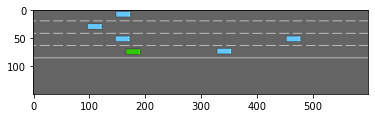

[[ 1.0000000e+00  1.0000000e+00  7.5000000e-01  3.2318053e-01
  -2.2220082e-08]
 [ 1.0000000e+00 -1.6012758e-02 -7.5000000e-01 -5.4582804e-02
   2.2220082e-08]
 [ 1.0000000e+00 -1.6561350e-02 -2.5000000e-01 -7.5193651e-02
   2.2220082e-08]
 [ 1.0000000e+00  1.4880662e-01 -7.3259554e-09 -6.6195264e-02
   2.2220082e-08]
 [ 1.0000000e+00  2.6093683e-01 -2.5000000e-01 -7.6121643e-02
   2.2220082e-08]]

Acción: IDLE -> recommpensa: 0.8705603713476432
Nuevo estado:


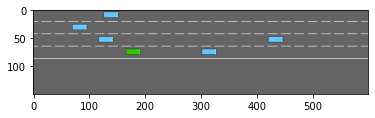

[[ 1.0000000e+00  1.0000000e+00  7.5000000e-01  3.1432518e-01
   2.8374927e-09]
 [ 1.0000000e+00 -3.5702538e-02 -7.5000000e-01 -4.5747194e-02
  -2.8374927e-09]
 [ 1.0000000e+00 -4.4502296e-02 -2.4999999e-01 -6.6389166e-02
  -2.8374927e-09]
 [ 1.0000000e+00  1.2449993e-01  1.2356016e-08 -5.7209641e-02
  -2.8374927e-09]
 [ 1.0000000e+00  2.3267467e-01 -2.4999999e-01 -6.7056037e-02
  -2.8374927e-09]]

Acción: IDLE -> recommpensa: 0.8673320549857544
Nuevo estado:


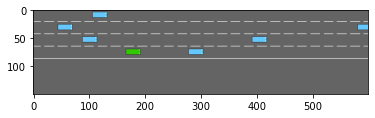

[[ 1.0000000e+00  1.0000000e+00  7.5000000e-01  3.1281191e-01
   1.2001009e-09]
 [ 1.0000000e+00  1.0200646e-01  3.5909942e-10 -5.5571459e-02
  -1.2001008e-09]
 [ 1.0000000e+00  2.0625696e-01 -2.5000000e-01 -6.5341853e-02
  -1.2001008e-09]
 [ 1.0000000e+00  3.7791336e-01 -5.0000000e-01 -4.4352315e-02
  -1.2001008e-09]
 [ 1.0000000e+00  4.6779144e-01  3.5909942e-10 -5.3150050e-02
  -1.2001008e-09]]

Acción: LANE_LEFT -> recommpensa: 0.8445581514796342
Nuevo estado:


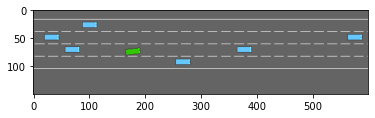

[[ 1.          1.          0.541812    0.3106928  -0.03405217]
 [ 1.          0.08102219  0.208188   -0.05333293  0.03405217]
 [ 1.          0.18137822 -0.041812   -0.06303053  0.03405217]
 [ 1.          0.3613835  -0.291812   -0.04229121  0.03405217]
 [ 1.          0.44776508  0.208188   -0.05097002  0.03405217]]

Acción: LANE_LEFT -> recommpensa: 0.8222416534167304
Nuevo estado:


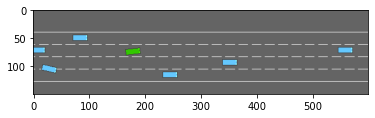

[[ 1.          1.          0.2781014   0.31065634 -0.03397922]
 [ 1.          0.06083861  0.4718986  -0.05318259  0.03397922]
 [ 1.          0.15732878  0.22189859 -0.06280993  0.03397922]
 [ 1.          0.34558412 -0.02810142 -0.04231402  0.03397922]
 [ 1.          0.42851466  0.4718986  -0.05088504  0.03397922]]

Acción: FASTER -> recommpensa: 0.9327737781679297
Nuevo estado:


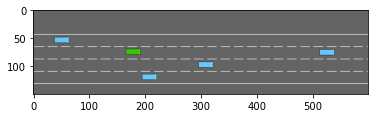

[[ 1.          1.          0.23100938  0.36431253  0.00248917]
 [ 1.          0.02639684  0.51899064 -0.10673049 -0.00248917]
 [ 1.          0.11904889  0.2689906  -0.11628956 -0.00248917]
 [ 1.          0.31545812  0.01899062 -0.09603079 -0.00248917]
 [ 1.          0.39497882  0.51899064 -0.10450403 -0.00248917]]

Acción: LANE_LEFT -> recommpensa: 0.9294401956139163
Nuevo estado:


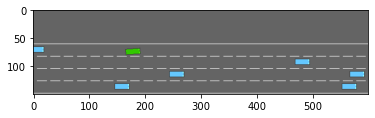

[[ 1.          1.          0.03977717  0.37175313 -0.03254614]
 [ 1.         -0.01758993  0.71022284 -0.11406834  0.03254614]
 [ 1.          0.07125098  0.46022284 -0.12356065  0.03254614]
 [ 1.          0.27572036  0.21022283 -0.10353324  0.03254614]
 [ 1.          0.3518686   0.71022284 -0.11191769  0.03254614]]

Acción: LANE_LEFT -> recommpensa: 0.9326680419013057
Nuevo estado:


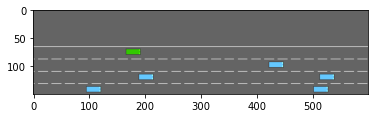

[[ 1.0000000e+00  1.0000000e+00 -1.4790065e-02  3.7468761e-01
   6.2882755e-04]
 [ 1.0000000e+00  2.1031652e-02  5.1479006e-01 -1.2633222e-01
  -6.2882755e-04]
 [ 1.0000000e+00  2.3346964e-01  2.6479006e-01 -1.0653080e-01
  -6.2882755e-04]
 [ 1.0000000e+00  3.0627942e-01  7.6479006e-01 -1.1483451e-01
  -6.2882755e-04]
 [ 1.0000000e+00  3.1562927e-01  5.1479006e-01 -1.2491198e-01
  -6.2882755e-04]]

Acción: LANE_LEFT -> recommpensa: 0.9332196428550023
Nuevo estado:


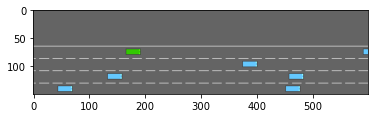

[[ 1.          1.         -0.00209817  0.3749417   0.00193806]
 [ 1.         -0.02953113  0.50209814 -0.12642959 -0.00193806]
 [ 1.          0.190786    0.25209817 -0.10684921 -0.00193806]
 [ 1.          0.26028827  0.75209814 -0.11507934 -0.00193806]
 [ 1.          0.26562566  0.50209814 -0.12505671 -0.00193806]]

Acción: LANE_LEFT -> recommpensa: 0.9333139049681977
Nuevo estado:


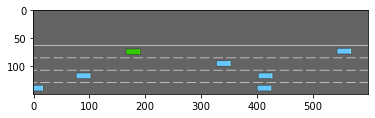

[[ 1.00000000e+00  1.00000000e+00  9.23615939e-04  3.74990880e-01
  -7.49366227e-05]
 [ 1.00000000e+00  1.48021773e-01  2.49076381e-01 -1.06963955e-01
   7.49366227e-05]
 [ 1.00000000e+00  2.14244723e-01  7.49076366e-01 -1.15126848e-01
   7.49366227e-05]
 [ 1.00000000e+00  2.15610534e-01  4.99076396e-01 -1.24999739e-01
   7.49366227e-05]
 [ 1.00000000e+00  3.43795985e-01 -9.23615939e-04 -1.08631589e-01
   7.49366227e-05]]
Episodio terminado después de 40 pasos y la recompensa fue 35.77252266965376


In [26]:
# Carga del modelo entrenado
modelo = torch.load("DQN.pth")['state_dic']
dqn.load_state_dict(modelo)

obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = dqn.get_action(obs, 0)
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
    print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))